# Bayesian modeling of Grid'5000 clusters

In [1]:
csv_url = 'https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv'
changelog_url = 'https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/exp_changelog.csv'
cluster = 'dahu'
factor = 'avg_gflops'

In [2]:
%load_ext autoreload
%autoreload 2
import requests
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from plotnine import *

In [3]:
import non_regression_tests as nrt

df = nrt.format(nrt.get(csv_url))

2020-03-10 15:06:49,306 - non_regression_tests - INFO - Downloaded a dataframe with 50767 rows and 26 columns


In [4]:
df = nrt.filter(df, cluster=cluster)

2020-03-10 15:06:49,347 - non_regression_tests - INFO - Filtered the dataframe, there remains 7536 rows


In [5]:
changelog = nrt.format_changelog(nrt.get(changelog_url))

2020-03-10 15:06:49,627 - non_regression_tests - INFO - Downloaded a dataframe with 4 rows and 5 columns


In [6]:
df = df[df['timestamp'] > changelog['date'].max()]
df['timestamp'].min()

Timestamp('2019-11-27 09:58:40')

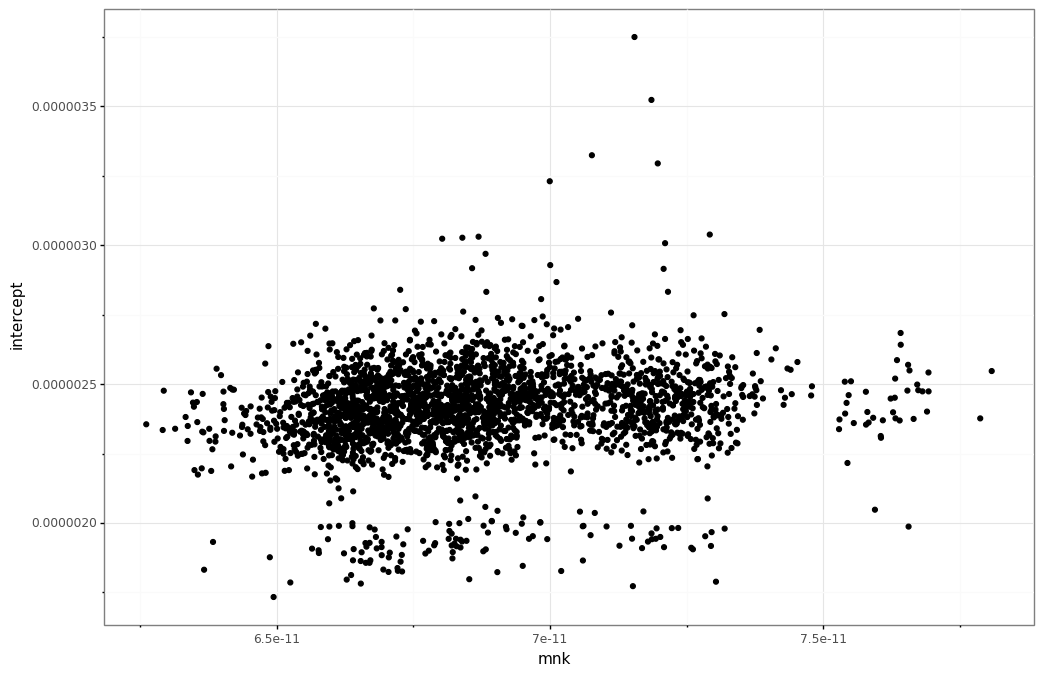

<ggplot: (8786498975429)>

In [7]:
ggplot(df) +\
    aes(x='mnk', y='intercept') +\
    geom_point() +\
    theme_bw()

In [8]:
import pystan
import numpy

In [9]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    int<lower=1> nb_nodes;
    matrix[nb_nodes,N] mnk;
    matrix[nb_nodes,N] intercept;

    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
    real<lower=0> prior_sigma;
    real<lower=0> prior_delta;
}
parameters {
    real<lower=0> hyper_alpha_raw;
    real<lower=0>  hyper_beta_raw;
    real<lower=0> sigma_raw;
    real<lower=0> delta_raw;

    vector<lower=0>[nb_nodes] alpha_raw;
    vector<lower=0>[nb_nodes]  beta_raw;
}
transformed parameters {
    real<lower=0> hyper_alpha;
    real<lower=0>  hyper_beta;
    real<lower=0>  sigma;
    real<lower=0>  delta;

    vector<lower=0>[nb_nodes] alpha;
    vector<lower=0>[nb_nodes]  beta;

    // Priors (defined as N(mu, mu))
    hyper_alpha = prior_alpha + hyper_alpha_raw*prior_alpha;
    hyper_beta  = prior_beta  + hyper_beta_raw*prior_beta;
    sigma = prior_sigma + sigma_raw*prior_sigma;
    delta = prior_delta + delta_raw*prior_delta;
    for(i in 1:nb_nodes){
       alpha[i] = hyper_alpha+alpha_raw[i]*hyper_alpha;
       beta[i]  = hyper_beta +beta_raw[i] *hyper_beta;
    }

}
model {
    // We define our priors
    alpha_raw ~ normal(0, 1);
    beta_raw ~ normal(0, 1);
    hyper_alpha_raw ~ normal(0, 1);
    hyper_beta_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    delta_raw ~ normal(0, 1);

    // Then, our likelihood function
    for(i in 1:nb_nodes) {
        alpha[i] ~ normal(hyper_alpha, hyper_alpha*sigma);
        beta[i] ~ normal(hyper_beta, hyper_beta*sigma);
        mnk[i] ~ normal(alpha[i], alpha[i]*delta);
        intercept[i] ~ normal(beta[i], beta[i]*delta);
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6af8b6350a17e26f2d82e74b97b412d NOW.


CPU times: user 1.07 s, sys: 41.5 ms, total: 1.11 s
Wall time: 1min 10s


In [10]:
min_count = int(df.groupby(['cluster', 'node', 'cpu'])[['expfile_hash']].count().min())
print(f'The least tested node has been tested {min_count} times')

The least tested node has been tested 35 times


CPU times: user 1.57 s, sys: 80 ms, total: 1.65 s
Wall time: 3.75 s


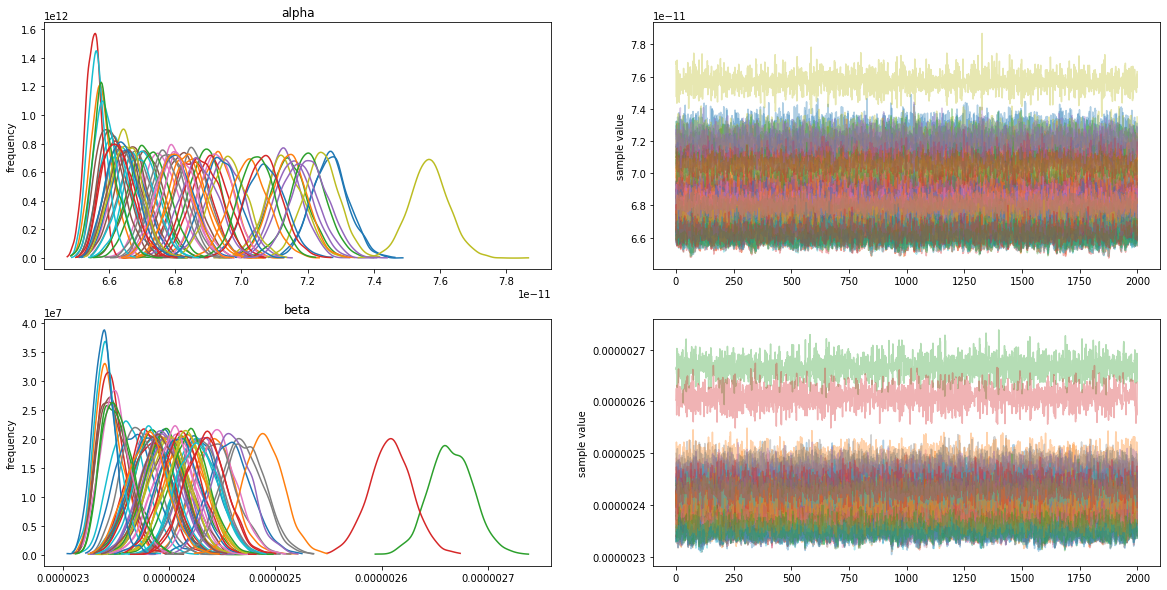

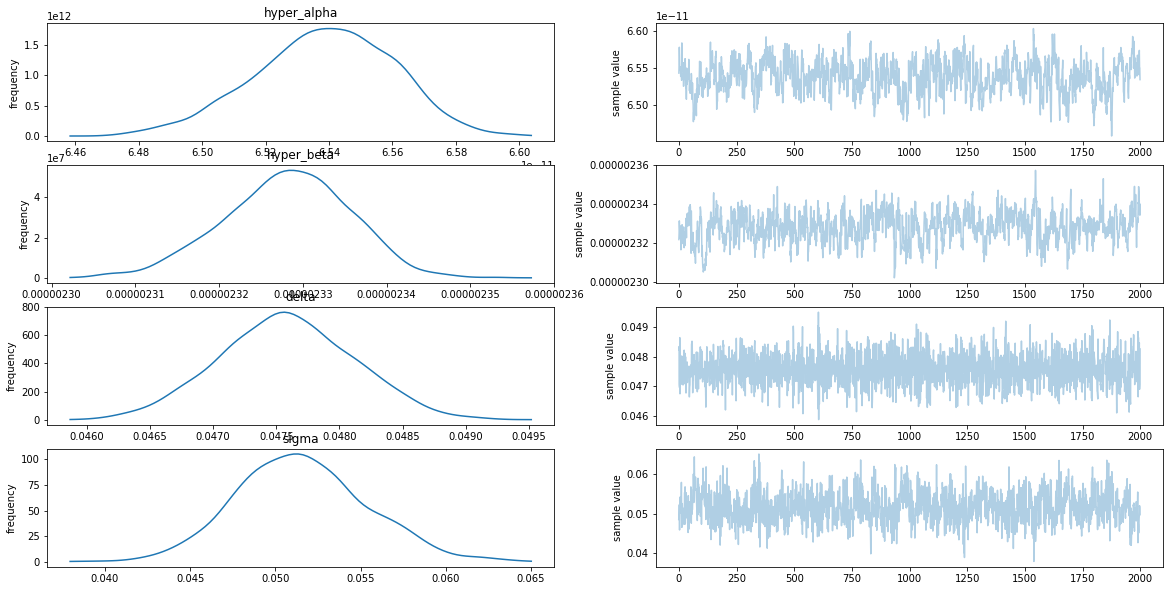

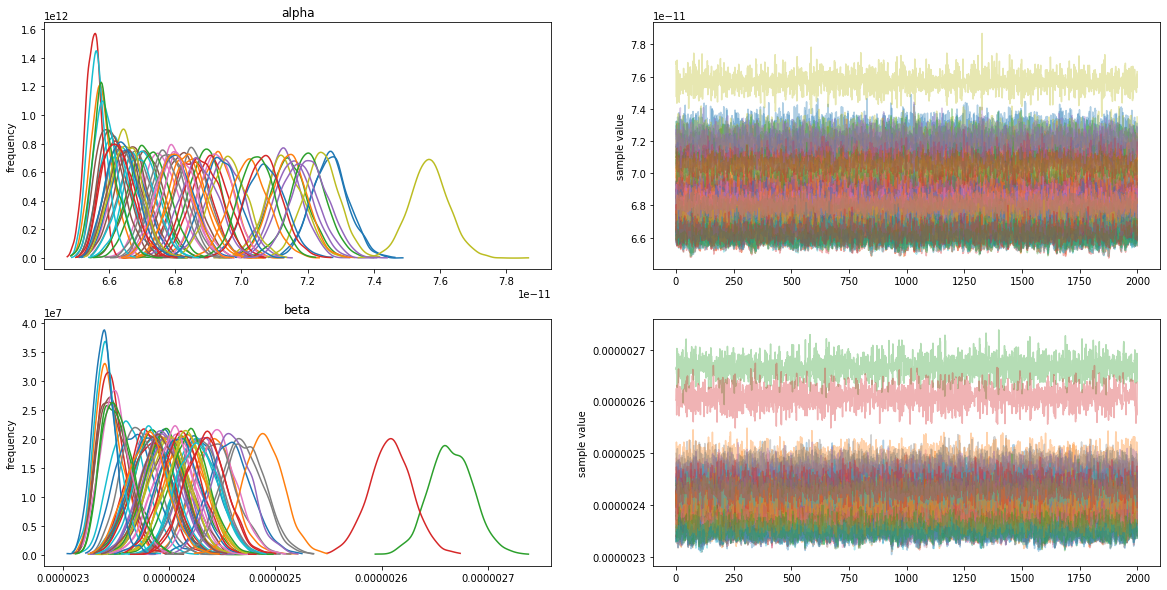

In [11]:
%%time

data = {
    'N': min_count,
    'nb_nodes': len(df[['node', 'cpu']].drop_duplicates()),
    'mnk': [],
    'intercept': [],
    'prior_alpha': 6.4e-11,
    'prior_beta': 2.3e-6,
    'prior_sigma': 0.03,
    'prior_delta': 0.03,
}

for _, row in df[['node', 'cpu']].drop_duplicates().iterrows():
    tmp = df[(df['node'] == row.node) & (df['cpu'] == row.cpu)]
    tmp = tmp.tail(n=min_count)
    data['mnk'].append(list(tmp['mnk']))
    data['intercept'].append(list(tmp['intercept']))

data['mnk'] = numpy.matrix(data['mnk'])
data['intercept'] = numpy.matrix(data['intercept'])

fit = sm.sampling(data=data, iter=500, chains=8)

fit.plot(['hyper_alpha', 'hyper_beta', 'delta', 'sigma'])
fit.plot(['alpha', 'beta'])

In [12]:
fit = sm.optimizing(data=data)

In [13]:
pandas.DataFrame(fit)[['hyper_alpha', 'hyper_beta', 'sigma', 'delta']].drop_duplicates()

,hyper_alpha,hyper_beta,sigma,delta
0,6.400010e-11,0.000002,0.065975,0.046891
